In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load dataset

In [2]:
X, odors = np.load('datasets/KC/features.npy'), np.load('datasets/KC/labels.npy')

In [3]:
x_dim, samples = X.shape

In [12]:
y = np.zeros(samples)

odor_1, odor_2 = 1, 7

samples_1, samples_2 = 0, 0

for t in range(samples):
    if odors[t]==odor_1: 
        y[t] = 1
        samples_1 += 1
    elif odors[t]==odor_2: 
        y[t] = 2
        samples_2 += 1
    else: y[t] = 0

In [13]:
epsilon = .01

# Optimal solution

In [14]:
# calculate class means 

mu01 = np.zeros(x_dim)
mu02 = np.zeros(x_dim)
mu1 = np.zeros(x_dim)
mu2 = np.zeros(x_dim)
cov_1 = np.zeros((x_dim,x_dim))
cov_2 = np.zeros((x_dim,x_dim))

for t in range(samples):
    if y[t] == 0:
        mu01 += X[:,t]
        mu02 += X[:,t]
    elif y[t] == 1:
        mu1 += X[:,t]
        mu02 += X[:,t]
    elif y[t] == 2:
        mu2 += X[:,t]
        mu01 += X[:,t]

    mu01 /= samples - samples_2
    mu02 /= samples - samples_1
    mu1 /= samples_1
    mu2 /= samples_2

# calculate sample variance

for t in range(samples):
    if y[t] == 0:
        cov_1 += np.outer(X[:,t]-mu01,X[:,t]-mu01)
        cov_2 += np.outer(X[:,t]-mu02,X[:,t]-mu02)
    elif y[t] == 1:
        cov_2 += np.outer(X[:,t]-mu02,X[:,t]-mu02)
    elif y[t] == 2:
        cov_1 += np.outer(X[:,t]-mu01,X[:,t]-mu01)

cov_1 /= samples - samples_1
cov_2 /= samples - samples_2

# add epsilon*identity to ensure that cov is invertible

cov_1 += epsilon*np.eye(x_dim)
cov_2 += epsilon*np.eye(x_dim)

In [15]:
w_opt_1 = np.zeros(x_dim)
w_opt_1 = np.linalg.inv(cov_1)@(mu01-mu1)
w_opt_norm_1 = np.linalg.norm(w_opt_1)
bias_opt_1 = .5*np.inner(w_opt_1,mu01+mu1)

w_opt_2 = np.zeros(x_dim)
w_opt_2 = np.linalg.inv(cov_2)@(mu02-mu2)
w_opt_norm_2 = np.linalg.norm(w_opt_2)
bias_opt_2 = .5*np.inner(w_opt_2,mu02+mu2)

# Bio-LDA

In [16]:
trials = 10; epochs = 10**2; eta0 = 1e-1; decay = 1e-3; iters = epochs*samples

In [17]:
error_1, error_2 = np.zeros((trials,iters)), np.zeros((trials,iters))
accuracy = np.zeros((trials,iters))

for trial in range(trials):

    print(f'Trial {trial+1}:')

    w_1 = np.random.randn(x_dim); sample_mu0_1 = 0; zeta_1 = 0; sample_bias_1 = 0; l_1 = 1
    w_2 = np.random.randn(x_dim); sample_mu0_2 = 0; zeta_2 = 0; sample_bias_2 = 0; l_2 = 1

    for epoch in range(epochs):

        idx = np.random.permutation(samples)

        for t in range(samples):

            iter = epoch*samples + t

            x, class_label = X[:,idx[t]], y[idx[t]]

            c_1, c_2 = np.inner(w_1,x), np.inner(w_2,x)

            step = eta0/(1+decay*iter)

            if class_label==0:

                sample_mu0_1 += (x-sample_mu0_1)/1000
                sample_mu0_2 += (x-sample_mu0_2)/1000
                sample_bias_1 += (c_1/2-sample_bias_1)/1000
                sample_bias_2 += (c_2/2-sample_bias_2)/1000
                zeta_1 += (c_1-zeta_1)/1000
                zeta_2 += (c_2-zeta_2)/1000

                w_1 += step*(sample_mu0_1-(c_1-zeta_1)*(x-sample_mu0_1))
                w_2 += step*(sample_mu0_2-(c_2-zeta_2)*(x-sample_mu0_2))
                l_1 += 1
                l_2 += 1

            elif class_label==1:

                sample_bias_1 += (l_1*c_1/2-np.log(l_1)-sample_bias_1)/1000
                w_1 += step*(sample_mu0_1-l_1*x)
                l_1 = 1

                sample_mu0_2 += (x-sample_mu0_2)/1000
                sample_bias_2 += (c_2/2-sample_bias_2)/1000
                zeta_2 += (c_2-zeta_2)/1000

                w_2 += step*(sample_mu0_2-(c_2-zeta_2)*(x-sample_mu0_2))
                l_2 += 1

            elif class_label==2:

                sample_bias_2 += (l_2*c_2/2-np.log(l_2)-sample_bias_2)/1000
                w_2 += step*(sample_mu0_2-l_2*x)
                l_2 = 1

                sample_mu0_1 += (x-sample_mu0_1)/1000
                sample_bias_1 += (c_1/2-sample_bias_1)/1000
                zeta_1 += (c_1-zeta_1)/1000

                w_1 += step*(sample_mu0_1-(c_1-zeta_1)*(x-sample_mu0_1))
                l_1 += 1

            # w_1 = np.maximum(w_1,0)
            # w_2 = np.maximum(w_2,0)

            z_1 = c_1-sample_bias_1
            z_2 = c_2-sample_bias_2

            error_1[trial,iter] = np.linalg.norm(w_1/np.linalg.norm(w_1)-w_opt_1/w_opt_norm_1)
            error_2[trial,iter] = np.linalg.norm(w_2/np.linalg.norm(w_2)-w_opt_2/w_opt_norm_2)
            
            if z_1>0 and z_2>0 and class_label==0: accuracy[trial,iter] = 1
            elif z_1<0 and z_2>0 and class_label==1: accuracy[trial,iter] = 1
            elif z_1>0 and z_2<0 and class_label==2: accuracy[trial,iter] = 1

Trial 1:
Trial 2:
Trial 3:
Trial 4:
Trial 5:
Trial 6:
Trial 7:
Trial 8:
Trial 9:
Trial 10:


In [18]:
mean_accuracy = np.zeros((trials,iters))

for trial in range(trials):

    for iter in range(iters):

        if iter<1000:
            mean_accuracy[trial,iter] = np.sum(accuracy[trial,0:iter])/max(iter,1)
        
        elif iter>=1000:
            mean_accuracy[trial,iter] = np.sum(accuracy[trial,iter-1000:iter])/1000

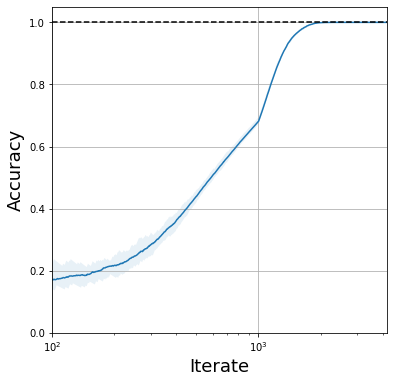

In [19]:
fs = 18

t = np.linspace(1,iters,iters)

fig = plt.figure(figsize=(6,6))

plt.semilogx(t,mean_accuracy.mean(axis=0))
plt.fill_between(t,np.amin(mean_accuracy,axis=0),np.amax(mean_accuracy,axis=0),alpha=.1)
plt.axhline(y=1,c='black',ls='--')
plt.xlim(1e2,iters)
plt.ylim(0,1.05)
plt.xlabel('Iterate',fontsize=fs)
plt.ylabel('Accuracy',fontsize=fs)
plt.grid()

plt.show()